In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import total_harmonic_distortion, BLUE_COLOR, min_max_scale, fft
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy.linalg import eig

plt.style.use(["science","bright","grid"])
# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"

### Parameter

In [169]:
AMPLITUDE_LIST  = [0.02,0.03,0.04,0.05,0.06,0.07,0.08]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_PARTICLES     = [5,9]

### Linear Time Constant

In [81]:
tau_t   = {}
freq_t  = {}
for N_P in N_PARTICLES:
    topo = {"Nx": N_P,"Ny": N_P,
            "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                    [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                    [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
            "electrode_type": ['constant']*8}
    
    sim_c   = Simulation(topo)
    sim_c.build_conductance_matrix()
    cap_m           = sim_c.get_capacitance_matrix()*1e-18
    g_m             = sim_c.get_conductance_matrix()[:-8,:-8]
    eigenvalues, _  = eig(g_m, cap_m)
    real_eigs       = np.real(eigenvalues)
    valid_eigs      = real_eigs[real_eigs > 1e-9]

    lambda_min  = np.min(valid_eigs)
    tau_t[N_P]  = 1.0 / lambda_min
    freq_t[N_P] = lambda_min / (2*np.pi)

In [204]:
G_to_drain

array([ 0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -4.e-08,
        0.e+00,  0.e+00,  0.e+00,  0.e+00])

In [ ]:
gains_lin = {}
src_idx   = 0
drain_idx = 1
for N_P in N_PARTICLES:
    topo = {"Nx": N_P,"Ny": N_P,
            "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                    [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                    [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
            "electrode_type": ['constant']*8}
    sim_c = Simulation(topo)
    sim_c.build_conductance_matrix()
    cap_m   = sim_c.get_capacitance_matrix()*1e-18
    cap_e   = sim_c.get_electrode_capacitance_matrix().T*1e-18
    g_m     = sim_c.get_conductance_matrix()
    G_II    = g_m[:-8,:-8]
    G_IE    = g_m[:-8,-8:]
    Phi_E   = np.array([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],dtype=complex)
    J_G     = - (G_IE @ Phi_E)
    
    G_to_drain = G_IE[:,-1]
    C_to_drain = cap_e[:,-1]

    output_currents = []
    
    for f in FREQ_LIST_MHZ:
        omega = 2 * np.pi * f *1e6
        
        # --- A. Build System Impedance Matrix (LHS) ---
        # Y_system = G_II + i*w*C_II
        Y_system = G_II + 1j * omega * cap_m
        
        # --- B. Build Driving Current Vector (RHS) ---
        # Capacitive injection: J_C = - i*w * C_elec * Phi_E
        # (This selects the column of C_elec corresponding to source)

        connected_mask = (np.abs(G_IE) > 0)
    
        # 2. Apply Mask to Electrode Capacitance
        # This forces the Capacitive coupling to be "Nearest Neighbor Only"
        # matching the topology of the Resistive grid.
        cap_e_filtered = cap_e * connected_mask
        
        J_C = - 1j * omega * (cap_e_filtered @ Phi_E)
        
        J_total = J_G + J_C
        
        # --- C. Solve for Internal Potentials ---
        # Phi_I = Y^-1 * J_total
        Phi_I = np.linalg.solve(Y_system, J_total)
        
        # --- D. Calculate Output Current at Drain ---
        # Current I_drain = Sum_over_internal_nodes( Phi_n * Y_n_to_drain )
        # The drain is at 0V, so we sum the current flowing FROM internal TO drain.
        
        # Admittance vector from Internal to Drain:
        Y_to_drain = G_to_drain + 1j * omega * C_to_drain
        
        # Dot product sums the contributions from all internal nodes
        I_out_complex = np.dot(G_to_drain, Phi_I)
        
        output_currents.append(np.abs(I_out_complex))

    # 6. Normalize to dB
    output_currents = np.array(output_currents)
    
    # Avoid division by zero if DC current is 0 (e.g. pure capacitor network)
    if output_currents[0] == 0:
        # Normalize to max if DC is zero
        ref_val = np.max(output_currents)
    else:
        ref_val = output_currents[0]
        
    gains_db = 20 * np.log10(output_currents / ref_val)
    gains_lin[N_P] = gains_db

### Load Data

In [ ]:
e_type  = 'constant'
dts     = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time    = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data    = {}
for N in N_PARTICLES:
    data_tmp = {amp : {freq : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{amp:.3f}_constant.csv") for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
    data[N]  = data_tmp

In [83]:
N = 9
x = {amp : {freq : data[N][amp][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}
y = {amp : {freq : data[N][amp][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for amp in AMPLITUDE_LIST}

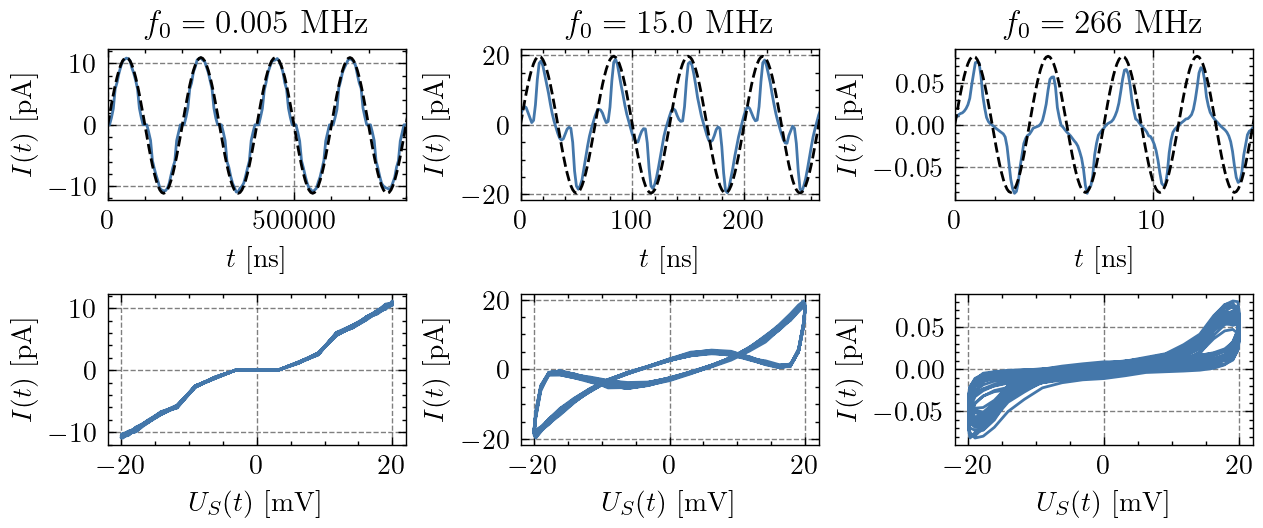

In [309]:
amp = 0.02
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
for i, freq in enumerate([0.005,15.,266]):
    ax      = fig.add_subplot(2,3,i+1)
    t_val   = time[freq].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[amp][freq].copy()
    y_val   = y[amp][freq].copy()*1e-6
    _       = ax.plot(t_val*1e9, y_val)
    _       = ax.plot(t_val*1e9, (y_val.max() - y_val.min())*(x_val-x_val.min()) / (x_val.max() - x_val.min()) - y_val.max(), color='black', ls='--')
    _       = ax.set_xlim(0,t_val[SAMPLE_P_PERIOD*4]*1e9)
    # _       = ax.set_ylim(-10,10)
    _       = ax.set_xlabel("$t$ [ns]")
    _       = ax.set_ylabel("$I(t)$ [pA]")
    _       = ax.set_title(f"$f_0 = {freq}$ MHz")
for i, freq in enumerate([0.005,15.,266]):
    ax      = fig.add_subplot(2,3,i+4)
    t_val   = time[freq].copy()[:-(N_SKIP*SAMPLE_P_PERIOD)-1]
    x_val   = x[amp][freq].copy()*1000
    y_val   = y[amp][freq].copy()*1e-6
    _       = ax.plot(x_val, y_val)
    _       = ax.set_xlabel("$U_S(t)$ [mV]")
    _       = ax.set_ylabel("$I(t)$ [pA]")

# fig.savefig(f"plots/pdf/drain_responses.pdf", transparent=False)
# fig.savefig(f"plots/svg/drain_responses.svg", transparent=True)
# fig.savefig(f"plots/png/drain_responses.png", transparent=False)

In [312]:
def gain_and_phase(n, N_periods=20):
    """
    Extracts magnitude and phase for the n-th harmonic.
    Assumes simulation contains exactly N_periods of the fundamental.
    """
    mags = {}
    phis = {}
    
    # Pre-calculate window (Blackman has great dynamic range for harmonics)
    # We assume all time series have the same length for a given f0? 
    # If length varies by freq, we must move this inside the loop.
    
    for amp in AMPLITUDE_LIST:
        mag_list = []
        phi_list = []
        
        for freq in FREQ_LIST_MHZ:
            y_val = y[amp][freq]
            N_samples = len(y_val)
            
            # 1. Apply Window to suppress leakage from n=1 into n=11
            window = np.blackman(N_samples)
            y_windowed = y_val * window
            
            # Window Coherent Gain Correction (important for correct amplitude!)
            # For Blackman, this factor is approx 2.38, but calculating it is safer.
            w_gain = np.sum(window) / N_samples
            
            # 2. Compute FFT once
            fft_vals = np.fft.rfft(y_windowed)
            
            # 3. Find Exact Index
            # Since T_run = N_periods / f0, the bin spacing is f0 / N_periods.
            # The n-th harmonic is at n * f0.
            # Therefore, the index is exactly: n * N_periods
            k = n * N_periods
            
            # Safety check: ensure k is within the FFT array
            if k < len(fft_vals):
                Z_k = fft_vals[k]
                
                # 4. Magnitude (Scaled and Corrected)
                # Mult by 2 for one-sided, divide by N, divide by window gain
                amplitude = (np.abs(Z_k) * 2 / N_samples) / w_gain
                mag_list.append(amplitude)
                
                # 5. Phase
                phi_list.append(np.angle(Z_k))
            else:
                # Harmonic is beyond the Nyquist frequency
                mag_list.append(np.nan)
                phi_list.append(np.nan)

        mags[amp] = np.array(mag_list)
        phis[amp] = np.array(phi_list)
        
    return mags, phis

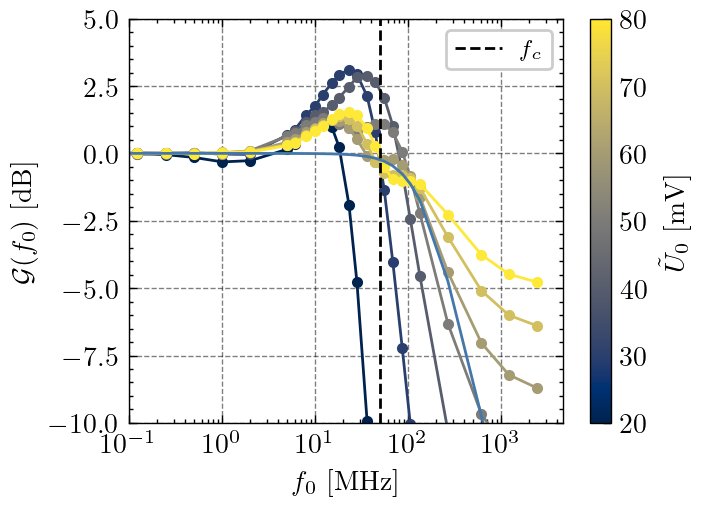

In [310]:
f_c         = freq_t[N]*1e-6
n           = 1
mags, phis  = gain_and_phase(n)
gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
tau_eff     = {amp : [-np.tan(phis[amp][i]/(2*np.pi*FREQ_LIST_MHZ[i]*1e6)) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}

norm    = Normalize(vmin=1000*AMPLITUDE_LIST[0], vmax=1000*AMPLITUDE_LIST[-1])
cmap    = plt.get_cmap('cividis')
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST:
    ax.plot(FREQ_LIST_MHZ, gain[amp], '.-', color=cmap(norm(1000*amp)))
ax.plot(FREQ_LIST_MHZ, gains_lin[9])
ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}(f_0)$ [dB]")
_ = ax.vlines(f_c, -10, 5, color='black', ls='--', label="$f_c$")
# _ = ax.hlines(-3, 1e-1, 1e4, color='black', ls=':', label="$\mathcal{G}(f_0) = -3$ dB")
_ = ax.set_xlim(1e-1)
_ = ax.set_ylim(-10,5)
_ = ax.legend(fontsize='small')

sm  = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$\\tilde{U}_0$ [mV]")
fig.savefig(f"plots/pdf/gain_n={n}.pdf", transparent=False)
fig.savefig(f"plots/svg/gain_n={n}.svg", transparent=True)
fig.savefig(f"plots/png/gain_n={n}.png", transparent=False)

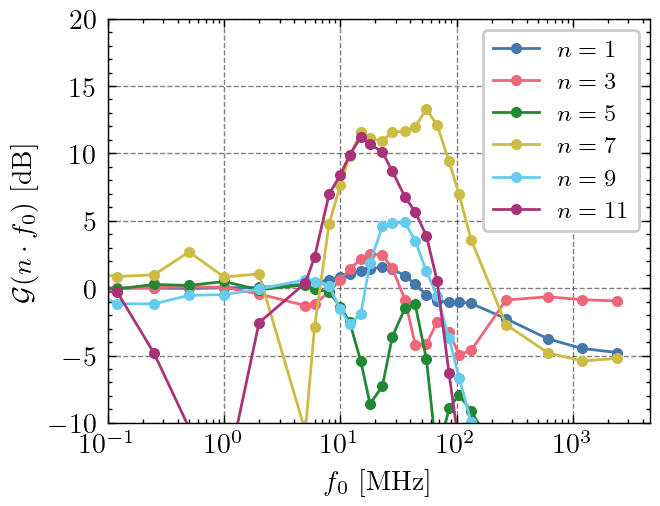

In [280]:
amp     = 0.08
norm    = Normalize(vmin=1000*AMPLITUDE_LIST[0], vmax=1000*AMPLITUDE_LIST[-1])
cmap    = plt.get_cmap('cividis')
fig, ax = plt.subplots(dpi=200)
vals    = []
for n in [1,3,5,7,9,11]:
    mags, phis  = gain_and_phase(n)
    if n == 1:
        ref_val = mags[amp][0]
    gain        = {amp : [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
    # gain        = {amp : [20*np.log10(mags[amp][i]/ref_val) for i in range(len(FREQ_LIST_MHZ))] for amp in AMPLITUDE_LIST}
    vals.append(gain[amp])
    ax.plot(FREQ_LIST_MHZ, gain[amp], '.-', label=f'$n = {n}$')

ax.set_xscale('log')
# ax.set_yscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}(n \cdot f_0)$ [dB]")
_ = ax.set_xlim(1e-1)
_ = ax.set_ylim(-10,20)
_ = ax.legend(fontsize='small', ncol=1)
# fig.savefig(f"plots/pdf/gain_vs_n.pdf", transparent=False)
# fig.savefig(f"plots/svg/gain_vs_n.svg", transparent=True)
# fig.savefig(f"plots/png/gain_vs_n.png", transparent=False)

In [295]:
th_val  = -3
cut_d   = {}
n_vals  = [1,3,5,7,9]
for amp in [0.02,0.03,0.06,0.07,0.08]:
    cuts = []
    for n in n_vals:
        mags, phis  = gain_and_phase(n)
        gain        = [20*np.log10(mags[amp][i]/mags[amp][0]) for i in range(len(FREQ_LIST_MHZ))]
        for i in range(len(gain)):
            if np.min(gain) > th_val:
                print(f"n={n}: bandwidth too high (never crosses {th_val}dB)")
                continue
            if gain[i] >= th_val > gain[i+1]:
                slope       = (FREQ_LIST_MHZ[i+1] - FREQ_LIST_MHZ[i]) / (gain[i+1] - gain[i])
                f_cross     = FREQ_LIST_MHZ[i] + slope * (th_val - gain[i])
                cutoff      = f_cross
                cuts.append(cutoff)
                break
    cut_d[amp] = cuts

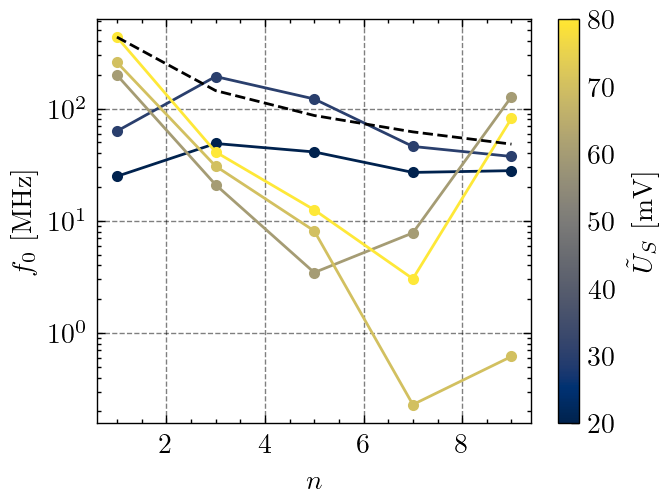

In [296]:
fig, ax = plt.subplots(dpi=200)
for amp in [0.02,0.03,0.06,0.07,0.08]:
    ax.plot(np.array(n_vals), cut_d[amp], color=cmap(norm(1000*amp)), marker='.')
ax.plot(np.array(n_vals), cut_d[amp][0]/np.array(n_vals), color='black', ls='--')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$n$")
ax.set_ylabel("$f_0$ [MHz]")

sm  = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$\\tilde{U}_S$ [mV]")

# fig.savefig(f"plots/pdf/f0_at_3db.pdf", transparent=False)
# fig.savefig(f"plots/svg/f0_at_3db.svg", transparent=True)
# fig.savefig(f"plots/png/f0_at_3db.png", transparent=False)

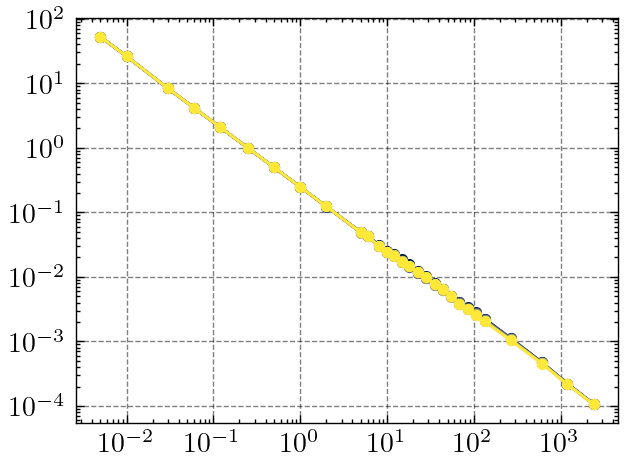

In [98]:
fig, ax = plt.subplots(dpi=200)
for amp in AMPLITUDE_LIST:
    ax.plot(FREQ_LIST_MHZ, np.abs(tau_eff[amp])*1e6, '.-', color=cmap(norm(1000*amp)))
ax.set_xscale('log')
ax.set_yscale('log')